In [23]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import pytz
import datetime as dt
from datetime import datetime, timedelta
import dateparser

import numpy as np
import pandas as pd

import time

from scipy.stats import linregress
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import os

import urllib.request

%matplotlib inline


In [3]:
data ="/Users/Grant/Desktop/hwy_df.csv"
hwy_df = pd.read_csv(data)

# Visualize

hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local
0,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46,2016-02-08 18:04,18:04
1,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23,2016-02-08 18:05,18:05
2,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21,2016-02-08 17:59,17:59
3,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41,2016-02-09 18:06,18:06
4,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23,2016-02-09 18:06,18:06


In [4]:
hwy_df['upper_limit'] = pd.DatetimeIndex(hwy_df['Sunset_Time_Local']) + timedelta(hours=2,minutes=0)
hwy_df['upper_limit']=hwy_df['upper_limit'].dt.time

In [5]:
hwy_df['lower_limit'] = pd.DatetimeIndex(hwy_df['Sunset_Time_Local']) + timedelta(hours=-2,minutes=0)
hwy_df['lower_limit'] = hwy_df['lower_limit'].dt.time

In [6]:
#Convert sunset_time string to a datetime object
hwy_df['Sunset_Time_Local_dt']= pd.to_datetime(hwy_df['Sunset_Time_Local'],format= '%H:%M' ).dt.time

In [7]:
#Convert accident_time string to a datetime object
hwy_df['Accident_Time_dt']= pd.to_datetime(hwy_df['Accident_Time'],format= '%H:%M' ).dt.time

In [8]:
hwy_west=hwy_df[hwy_df['Direction']=='W']

In [9]:
#Check if Accident Time is within the +- 2 hour window from sunset
hwy_west['In_Window']= np.logical_and(hwy_west['lower_limit'] < hwy_west['Accident_Time_dt'], hwy_west['upper_limit'] > hwy_west['Accident_Time_dt'])


In [10]:
hwy_west=hwy_west.reset_index(drop =True)

In [11]:
type(hwy_west['Sunset_Time_Local_dt'][1])

datetime.time

In [12]:
type(hwy_west['Sunset_Time_Local'][1])

str

In [14]:
time_delt=[]

datetimeFormat = '%H:%M'

for index in hwy_west.index:
    date1 = hwy_west['Sunset_Time_Local'][index]
    date2 = hwy_west['Accident_Time'][index]
    diff = dt.datetime.strptime(date2, datetimeFormat) - dt.datetime.strptime(date1, datetimeFormat)
    diff2=(diff.total_seconds())/60
    time_delt.append(diff2)

hwy_west['Time Delta']=time_delt

In [15]:
sunset_df=hwy_west[hwy_west['In_Window']==True]

In [16]:
sunset_df.head(2)

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,upper_limit,lower_limit,Sunset_Time_Local_dt,Accident_Time_dt,In_Window,Time Delta
14,810,CA,3,6/21/16 20:03,6/21/16 20:48,37.766987,-121.335495,0.0,Two lanes blocked due to accident on I-205 Wes...,NaN,...,2016-06-21 03:31,20:03,2016-06-20 20:31,20:31,22:31:00,18:31:00,20:31:00,20:03:00,True,-28.0
20,931,CA,3,6/22/16 18:45,6/22/16 19:15,37.830669,-122.293343,0.0,Accident on I-80 I-580 Westbound at Exit 19A I...,NaN,...,2016-06-22 03:35,18:45,2016-06-21 20:35,20:35,22:35:00,18:35:00,20:35:00,18:45:00,True,-110.0


In [17]:
bins = [-120, -80, -40, 0, 40, 80, 120]

In [17]:
np.arange(-120,135,20)

array([-120, -100,  -80,  -60,  -40,  -20,    0,   20,   40,   60,   80,
        100,  120])

In [18]:
group_names=['120-80min before Sunset', '80-40min before Sunset', '40-0min before Sunset', \
            '0-40min after Sunset', '40-80min after Sunset', '80-120min after Sunset']

In [19]:
sunset_df['Time_From_Sunset_Bin']=pd.cut(sunset_df["Time Delta"], bins, labels=group_names)


In [20]:
sunset_df['Time_From_Sunset_Bin'].value_counts()

120-80min before Sunset    1646
80-40min before Sunset     1609
40-0min before Sunset      1413
0-40min after Sunset       1313
40-80min after Sunset      1238
80-120min after Sunset     1005
Name: Time_From_Sunset_Bin, dtype: int64

In [72]:
os.makedirs(os.path.join('output_data'),exist_ok=True)


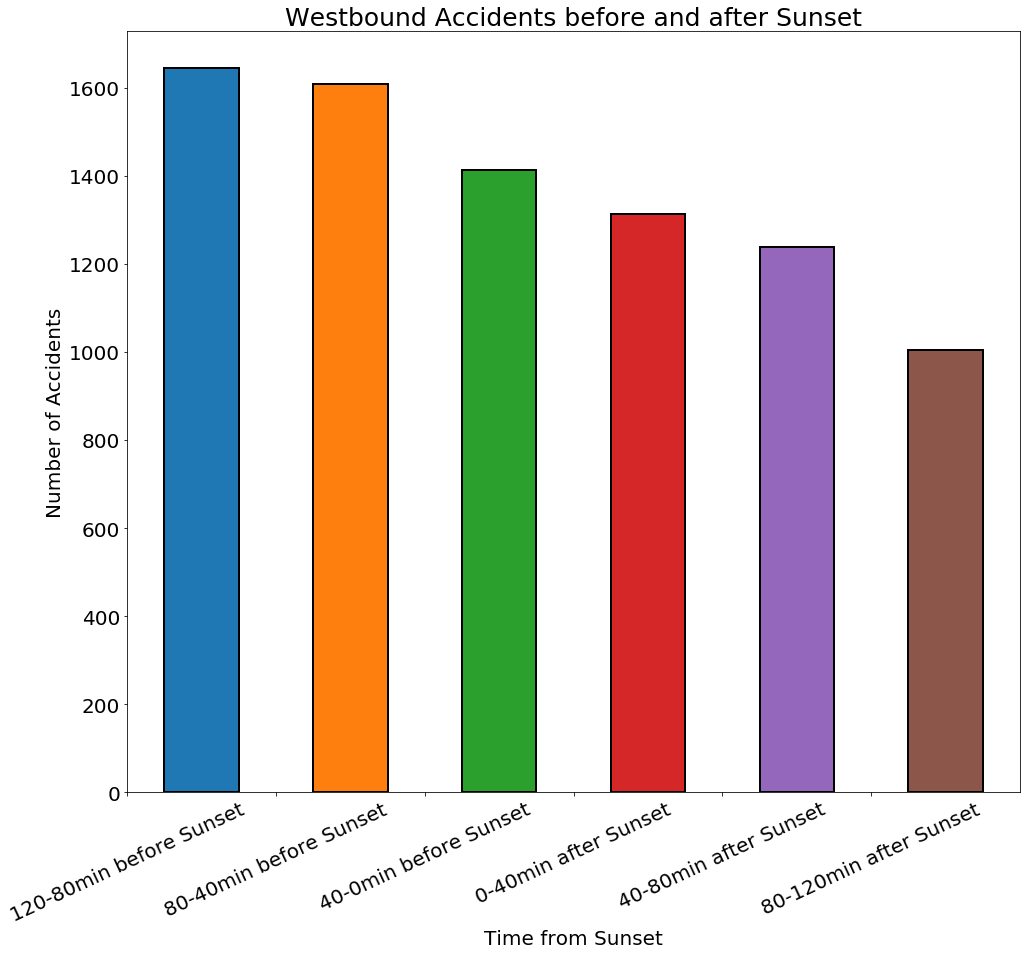

In [21]:
fig, ax = plt.subplots(figsize=(16,14))
sunset_df['Time_From_Sunset_Bin'].value_counts().plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Time from Sunset',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('Westbound Accidents before and after Sunset',fontsize=25)
#tick_locations = [value for value in x_axis]
plt.xticks(np.arange(6)-.5, rotation=25)

#plt.savefig(os.path.join('output_data',f'Westbound accidents before and after sunset.png'))
plt.show()

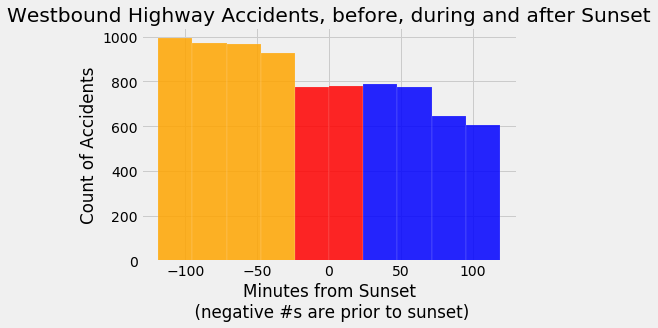

In [89]:

fig, ax = plt.subplots()
data = sunset_df['Time Delta']


N, bins, patches = ax.hist(data, edgecolor='white', alpha=0.85, linewidth=0.15)

for i in range(0,4):
    patches[i].set_facecolor('orange')
for i in range(4,6):    
    patches[i].set_facecolor('red')
for i in range(6, 10):
    patches[i].set_facecolor('blue')

ax.set_xlabel('Minutes from Sunset\n (negative #s are prior to sunset)')
ax.set_ylabel('Count of Accidents')
ax.set_title(r'Westbound Highway Accidents, before, during and after Sunset')

plt.show()
plt.savefig(os.path.join('output_data',f'Histogram of westbound accidents before and after sunset.png'))